In [ ]:
# Install and import the needed libraries
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [3]:
import cv2
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM (out of memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
# create data directory and consider only image file format types
# each folder is a category, folder berge is a category mountains and folder stadt is a category city
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [76]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 155 files belonging to 2 classes.


In [77]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

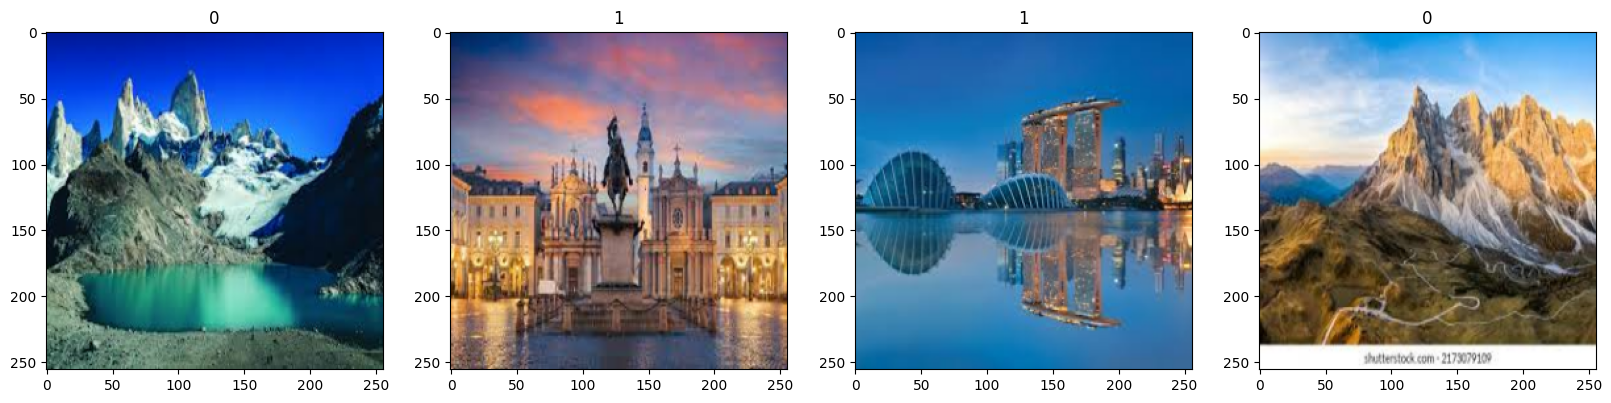

In [62]:
# establish the data pipeline to load the data
# there are 155 files belonging to 2 classes: class 0 - mountains, class 1 - city
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
# Scale the data
# map function enenbles transformation inside the pipeline
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

In [ ]:
# The batch size is the number of samples processed before the model changes.
# The number of epochs is the number of complete iterations of the training dataset.
# A batch must have a minimum size of one and a maximum size that is less than or equal to the number of samples in the training dataset.

In [64]:
# Split the Data to: 70% Train, 20% Validation and 10% Test
# number of batches is dependent on total sample size
train_size = int(len(data)*.7) # training set will be 70% of data, in our case 3
val_size = int(len(data)*.2) # validation set size will be 20% of data,in our case 1
test_size = int(len(data)*.1) # test size will be 10%, in our case 0

In [65]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [66]:
# Build the deep Learning Model
from tensorflow.keras.models import Sequential # import sequential API. Sequential is good for 1 data input.
# Functional API would be more complicated, for multi input.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # import needed layers
# MaxPooling2D is condensing image down

In [67]:
model = Sequential() # create a model with sequential class

In [68]:
# Layers are added sequentialy
# 1st layer: convolution has 16 filters ( 3 x 3 pixels inside).
# The power is coming from activation function. Relu is replacing null values.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# 2nd layer - choose maximum value after the relu activation (2 x 2)
model.add(MaxPooling2D())
# 3rd layer, output is only 1 value, use 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# 4th layer
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# flatten the data again down
model.add(Flatten())
# convolution has 2 Dense layers
model.add(Dense(256, activation='relu')) # output is 256 values
# The final sigmoid layer, close to 0 are mountains, close to 1 is the city
# Sigmoid activation is non-linear, continuously differentiable, monotonic, and has a fixed output range. Main advantage is simple and good for classifier.
# Sigmoid activation gives rise to a problem of “vanishing gradients” because Its output isn’t zero centered. Sigmoid activation is computationaly more expensive.
model.add(Dense(1, activation='sigmoid')) # single dense layer is the final layer, converts values between 0 and 1

In [69]:
# The model uses the efficient Adam optimization algorithm for gradient descent, to adjusts the weights of the network and to minimize the loss function.
# Binary Crossentropy computes the cross-entropy loss between true labels and predicted labels.
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()
# if the layer is not trainable, there is 0 in Param column
# total params stands for the total size of our model

In [29]:
# Train the model
# Create a folder to save your callbacks
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
# Fitting the model. Loss is decresing with each epoch and accuracy is raising.
# The last epoch has 95% accuracy.
# Over a series of epochs, the model is able to distinguish between dominating and certain low-level features in images and classify them using the sigmoid classification technique in the second dense layer.
# 11 is a sufficient epoch count, more epochs does not lead to better model performance
hist = model.fit(train, epochs=11, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/11
3/3 [==============================] - 7s 2s/step - loss: 0.1795 - accuracy: 0.9271 - val_loss: 0.1034 - val_accuracy: 0.9688
Epoch 2/11
3/3 [==============================] - 9s 4s/step - loss: 0.1856 - accuracy: 0.9479 - val_loss: 0.0900 - val_accuracy: 1.0000
Epoch 3/11
3/3 [==============================] - 8s 3s/step - loss: 0.1052 - accuracy: 0.9583 - val_loss: 0.0697 - val_accuracy: 1.0000
Epoch 4/11
3/3 [==============================] - 5s 2s/step - loss: 0.0670 - accuracy: 0.9896 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 5/11
3/3 [==============================] - 5s 2s/step - loss: 0.0625 - accuracy: 0.9792 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 6/11
3/3 [==============================] - 6s 2s/step - loss: 0.0511 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 7/11
3/3 [==============================] - 7s 2s/step - loss: 0.0733 - accuracy: 0.9792 - val_loss: 0.0345 - val_accuracy: 1.0000
Epoch 8/11
3/3 [=========================

In [ ]:
hist.history

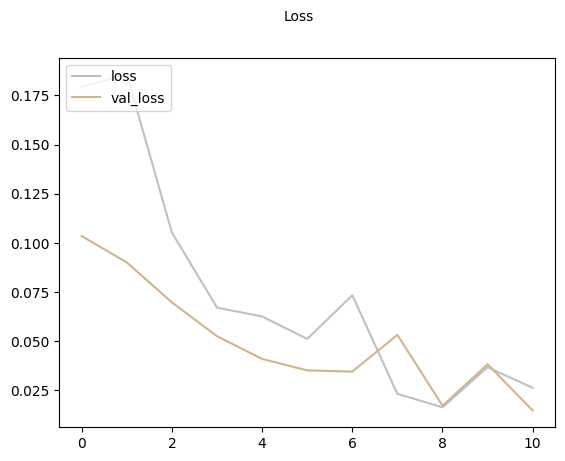

In [53]:
# Revise the model Performance
# if loss and validation go down: OK
# if loss goes down, but validation goes up: model is overfitting. You must change the data.
# if loss or valiadation is constant, model is not able to learn and you must change more parameters.
fig = plt.figure()
plt.plot(hist.history['loss'], color='silver', label='loss')
plt.plot(hist.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()

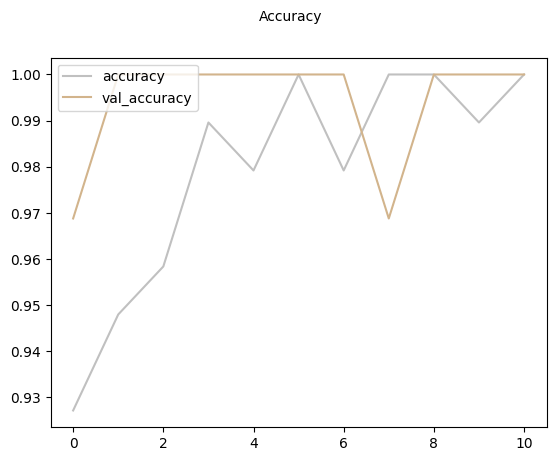

In [54]:
# ideal would be to result in accuracy 100%. Consider more files to increase the accuracy.
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='silver', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

In [55]:
# Evaluate the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [56]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

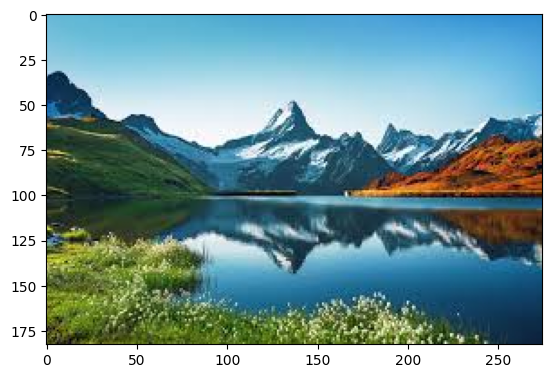

In [57]:
# Test the model
# read the image that was not used in training
img = cv2.imread('test.jpeg') # bgr colors
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) # change bgr colors to rgb
plt.show()

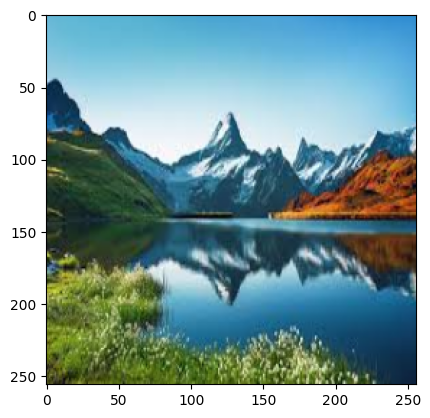

In [40]:
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256)) # resize the image
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
resize

In [ ]:
# display the shape of resized image
resize.shape

In [ ]:
# expand the shape of a resized image
# insert a new axis that will appear at the axis position in the expanded array shape.
np.expand_dims(resize,0)

In [ ]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [74]:
test_prediction = model.predict(np.expand_dims(resize/255, 0))
# we devide it by 255 to scale the result

1/1 [==============================] - 0s 100ms/step


In [61]:
test_prediction # closer to mountains ( our scale: 0 mountains and 1 for city)

array([[8.380818e-05]], dtype=float32)

In [52]:
if test_prediction > 0.5:
    print(f'Predicted class is City')
else:
    print(f'Predicted class is Mountains')

Predicted class is Mountains


In [50]:
# Save the model
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# https://en.wikipedia.org/wiki/Convolutional_neural_network
# https://datascientest.com/en/epoch-an-essential-notion#:~:text=A%20larger%20number%20of%20epochs,iterative%20process%20of%20gradient%20descent.
# https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/
# https://www.tensorflow.org/tutorials/video/video_classification
# https://github.com/nicknochnack/ImageClassification/tree/main
# https://www.youtube.com/watch?v=jztwpsIzEGc&t=811s
# https://cs.stanford.edu/people/nick/py/python-map-lambda.html
# https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/
# https://medium.com/@cmukesh8688/activation-functions-sigmoid-tanh-relu-leaky-relu-softmax-50d3778dcea5
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
